In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from pathlib import Path
import uproot
import pandas as pd

In [2]:
# Load data
cwd = os.getcwd()
folder = Path(cwd) / "output"
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)
hits = f["Singles1"]

# Load relevant branches
arrays = hits.arrays([
    "PostPosition_X", "PostPosition_Y", "PostPosition_Z", 
    "TotalEnergyDeposit", "GlobalTime"
], library="np")

# Combine into DataFrame
df = pd.DataFrame(arrays)
print(f"Loaded {len(df)} hits.")

df.head()
print(df.shape)

Loaded 455764 hits.
(455764, 5)


In [3]:
def find_coincidences(df: pd.DataFrame, time_window: float, 
                      energy_center: float = 0.511, delta_e: float = 0.3) -> pd.DataFrame:
    """
    Find photon coincidences within a time window and an energy window,
    with rejection of multiple coincidences (only accept exactly one partner photon).
    
    Prints how many multiple coincidences were rejected.
    
    Parameters:
        df (pd.DataFrame): Photon data with columns:
            ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
             "TotalEnergyDeposit", "GlobalTime", "LocalTime"]
        time_window (float): Time difference (same units as 'GlobalTime') for coincidences.
        energy_center (float): Center of the allowed energy window (default: 511 keV).
        delta_e (float): Half-width of energy window. Both photons must have energy in
                         [energy_center - delta_e, energy_center + delta_e].
        
    Returns:
        pd.DataFrame: DataFrame of coincidence pairs with suffixed columns.
    """
    # Sort by GlobalTime
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].to_numpy()
    energy = df_sorted["TotalEnergyDeposit"].to_numpy()
    
    # Define energy bounds
    e_min = energy_center - delta_e
    e_max = energy_center + delta_e
    
    result_rows = []
    colnames = df.columns
    
    # Counters
    multiple_rejections = 0
    accepted_pairs = 0
    
    for i in range(len(df_sorted)):
        t0 = times[i]
        e0 = energy[i]
        
        if not (e_min <= e0 <= e_max):
            continue
        
        j_start = i + 1
        j_end = np.searchsorted(times, t0 + time_window, side='right')
        
        candidates = df_sorted.iloc[j_start:j_end]
        mask = (candidates["TotalEnergyDeposit"] >= e_min) & (candidates["TotalEnergyDeposit"] <= e_max)
        candidates = candidates[mask]
        
        # --- Multiple coincidence rejection ---
        if len(candidates) != 1:
            if len(candidates) > 1:
                multiple_rejections += 1  # Count suspected multiple coincidences
            continue  # Always skip if not exactly one candidate
        # --------------------------------------
        
        # Accept the single matching photon
        row2 = candidates.iloc[0]
        row1 = df_sorted.iloc[i]
        
        combined = [row1[col] for col in colnames] + [row2[col] for col in colnames]
        result_rows.append(combined)
        
        accepted_pairs += 1

    # Final dataframe
    columns = [f"{col}_1" for col in colnames] + [f"{col}_2" for col in colnames]
    coincidences_df = pd.DataFrame(result_rows, columns=columns)
    
    # Print summary
    print(f"Coincidence finding summary:")
    print(f"  Accepted pairs: {accepted_pairs}")
    print(f"  Rejected suspected multiple coincidences: {multiple_rejections}")
    
    return coincidences_df

In [5]:
def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    thetas = []
    rs = []

    for _, row in coincidences_df.iterrows():
        x1, y1 = row["PostPosition_X_1"], row["PostPosition_Y_1"]
        x2, y2 = row["PostPosition_X_2"], row["PostPosition_Y_2"]

        # Compute the midpoint of the LOR.
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0

        # Orientation of the LOR (angle of the line connecting the two points)
        phi = np.arctan2(y2 - y1, x2 - x1)

        # The sinogram parameter theta is the angle of the normal to the LOR.
        theta = (phi + np.pi/2) % np.pi  # in radians

        # r is the projection of the midpoint onto the normal.
        r = xm * np.cos(theta) + ym * np.sin(theta)

        thetas.append(theta)
        rs.append(r)

    thetas = np.array(thetas)
    rs = np.array(rs)

    # Convert theta from radians to degrees.
    thetas_deg = np.degrees(thetas)

    # Define histogram bin edges.
    theta_edges = np.linspace(0, 180, bins_theta + 1)
    r_min, r_max = rs.min(), rs.max()
    r_edges = np.linspace(r_min, r_max, bins_r + 1)

    # Create 2D histogram: rows are r bins, columns are theta bins.
    sinogram, _, _ = np.histogram2d(rs, thetas_deg, bins=[r_edges, theta_edges])

    # Compute theta bin centers.
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2.0

    return sinogram, theta_centers, r_edges


In [4]:
#Finding Coincident Photons
time_window = 1.0  # example time window value... around 30cm diameter tansverse FOV
energy_half_range = 0.051 # 10% energy resolution assumed

coincidences_df = find_coincidences(df, time_window, delta_e= energy_half_range)

Coincidence finding summary:
  Accepted pairs: 3887
  Rejected suspected multiple coincidences: 2


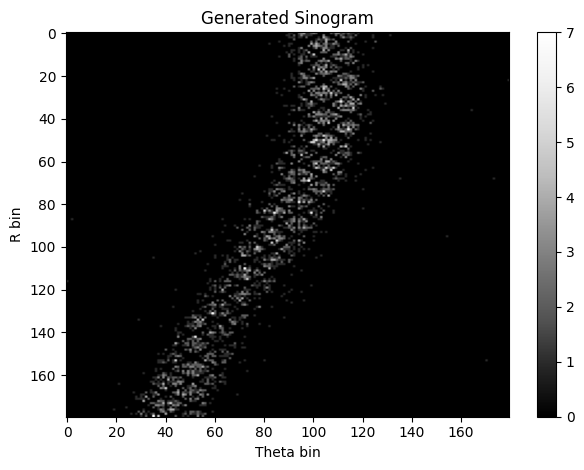

In [10]:
#Generating the Sinogram
sinogram, theta_centers, r_edges = compute_sinogram(coincidences_df)

plt.imshow(sinogram.T, cmap="Greys_r", aspect="auto")
plt.xlabel("Theta bin")
plt.ylabel("R bin")
plt.title("Generated Sinogram")
plt.colorbar()
plt.tight_layout()
#plt.savefig("output/sinogram_preview.png")  #save preview image
plt.show()


In [ ]:
#Saving the Sinogram to a folder

# Save sinogram and metadata
np.savez("output/sinogram_data.npz",
         sinogram=sinogram,
         theta_centers=theta_centers,
         r_edges=r_edges)

#Saving coincidences_df
coincidences_df.to_csv("output/coincidences.csv", index=False)